## Условия

В работе используется открытый датасет: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset

Структуры данных в проекте:

ctr_test_task/
- fashion-dataset/
- - images_train/
- - images_train_target/
- - images_test/
- - images_test_target/
- - ctr_test_task.ipynb

Для демонстрации я выбрал первые две тысячи снимков из общего количества изображений: тысяча на тренировочный набор (номера 1163-2985) и тысяча на тестовый (номера 2986-4119).

В качестве изображений с высоким CTR я выбрал:
- снимки, где присутствует только футболка с коротким рукавом (нет людей и других предметов одежды);
- снимки людей в полосатой одежде (только верх, клетку не берем);
- снимки с фоном.

Получилось 268 снимков в тренировочном наборе и 180 в тестовом.

В качестве табличных данных я использовал json'ы из папки "styles", поскольку там больше информации о каждом товаре. Оттуда я всял все данные из раздела "data", но без вложенных данных - они зачастую дублируют информацию из верхнего раздела.

In [74]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import os
import random
import shutil
import json

import cv2
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import networkx as nx
from networkx.algorithms import community
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# Для получения эбеддингов изображений используем ImageNetV2B0 с входным разрешением 224x224
IMG_SIZE = 224

print('Размер изображений:', IMG_SIZE)

Размер изображений: 224


## Расположение данных

In [4]:
TRAIN_IMG_DIR = os.path.join('fashion-dataset', 'images_train')
TRAIN_TARGET_DIR = os.path.join('fashion-dataset', 'images_train_target')

TEST_IMG_DIR = os.path.join('fashion-dataset', 'images_test')
TEST_TARGET_DIR = os.path.join('fashion-dataset', 'images_test_target')

STYLES_DIR = os.path.join('fashion-dataset', 'styles')

## Загрузка данных

In [94]:
# Функция для показа изображений
def show_image_grid_from_paths(paths, labels=None, rows=10, cols=10, figsize=(15, 15), resize_to=(400, 400)):
    # Показываем не больше total изображений
    total = rows * cols
    if len(paths) > total:
        paths = paths[:total]

    loaded_images = []
    titles = []
    for p in paths:
        if not os.path.isfile(p):
            msg = f'File not found: {p}'
            print(msg)
            loaded_images.append(None)
            continue
        try:
            with Image.open(p) as im:
                im.thumbnail(resize_to, Image.LANCZOS)
                arr = np.array(im)
                loaded_images.append(arr)

            title = os.path.basename(p)
            
            if labels is not None:
                img_name = os.path.splitext(title)[0]
                label = labels[img_name]
                title += ' ' + label
            
            titles.append(title)
        except Exception as e:
            msg = f'Failed to open {p}: {e}'
            print(msg)
            loaded_images.append(None)

    # Добавим пустые ячейки, если изображений больше чем ячеек
    while len(loaded_images) < total:
        loaded_images.append(None)

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes_flat = axes.ravel()

    for i in range(total):
        ax = axes_flat[i]
        img = loaded_images[i]
        ax.set_xticks([])
        ax.set_yticks([])
        if img is None:
            ax.axis("off")
            continue
        else:
            ax.set_title(titles[i], fontsize=8)

        ax.imshow(img)

    plt.show()
    return fig, axes

In [9]:
# Получим список табличных признаков

features_list = []

# Количество признаков варьируется на 1-2, в зависимости от изображения.
# Чтобы добиться единообразия - в качестве стандарта возьмем признаки у первого изображения из нашего набора данных
json_path = os.path.join(STYLES_DIR, '1163.json')
with open(json_path, 'r', encoding='utf-8') as f:
    json_data = json.load(f)

    # Получим содержимое раздела 'data'
    product_data = json_data['data']

    for key, value in product_data.items():
        # Исключим вложенные параметры
        if not isinstance(value, (dict, list)):
            features_list.append(key)

print(f'Список табличных признаков: {features_list} ({len(features_list)} всего).')

Список табличных признаков: ['id', 'price', 'discountedPrice', 'styleType', 'productTypeId', 'articleNumber', 'visualTag', 'productDisplayName', 'variantName', 'myntraRating', 'catalogAddDate', 'brandName', 'ageGroup', 'gender', 'baseColour', 'colour1', 'colour2', 'fashionType', 'season', 'year', 'usage', 'vat', 'displayCategories', 'weight', 'navigationId', 'landingPageUrl', 'codEnabled', 'isEMIEnabled'] (28 всего).


#### Тренировочные данные

In [10]:
# Получим имена всех тренировочных изображений
train_images = [f for f in os.listdir(TRAIN_IMG_DIR)]
train_ids = [os.path.splitext(filename)[0] for filename in train_images]
print(f'Тренировочные изображения: {train_ids[0]}-{train_ids[len(train_ids)-1]} ({len(train_ids)} всего).')

train_targets = [f for f in os.listdir(TRAIN_TARGET_DIR)]
train_target_ids = [os.path.splitext(filename)[0] for filename in train_targets]
print(f'Тренировочные изображения с высоким CTR: {train_target_ids} ({len(train_target_ids)} всего).')

Тренировочные изображения: 1163-2985 (1000 всего).
Тренировочные изображения с высоким CTR: ['1163', '1164', '1165', '1525', '1529', '1530', '1532', '1535', '1538', '1541', '1543', '1544', '1545', '1546', '1547', '1548', '1549', '1550', '1551', '1552', '1553', '1554', '1555', '1556', '1557', '1558', '1559', '1565', '1566', '1567', '1572', '1577', '1578', '1580', '1581', '1582', '1584', '1588', '1591', '1592', '1595', '1597', '1598', '1599', '1612', '1613', '1614', '1615', '1618', '1620', '1621', '1626', '1627', '1628', '1637', '1638', '1644', '1645', '1646', '1648', '1653', '1657', '1670', '1671', '1673', '1678', '1689', '1697', '1754', '1756', '1757', '1758', '1759', '1760', '1764', '1782', '1783', '1787', '1802', '1805', '1806', '1907', '1909', '1910', '1911', '1912', '1913', '1934', '1951', '1997', '2001', '2010', '2011', '2029', '2110', '2113', '2143', '2144', '2145', '2146', '2147', '2148', '2149', '2150', '2151', '2152', '2153', '2154', '2155', '2171', '2172', '2176', '2177', '21

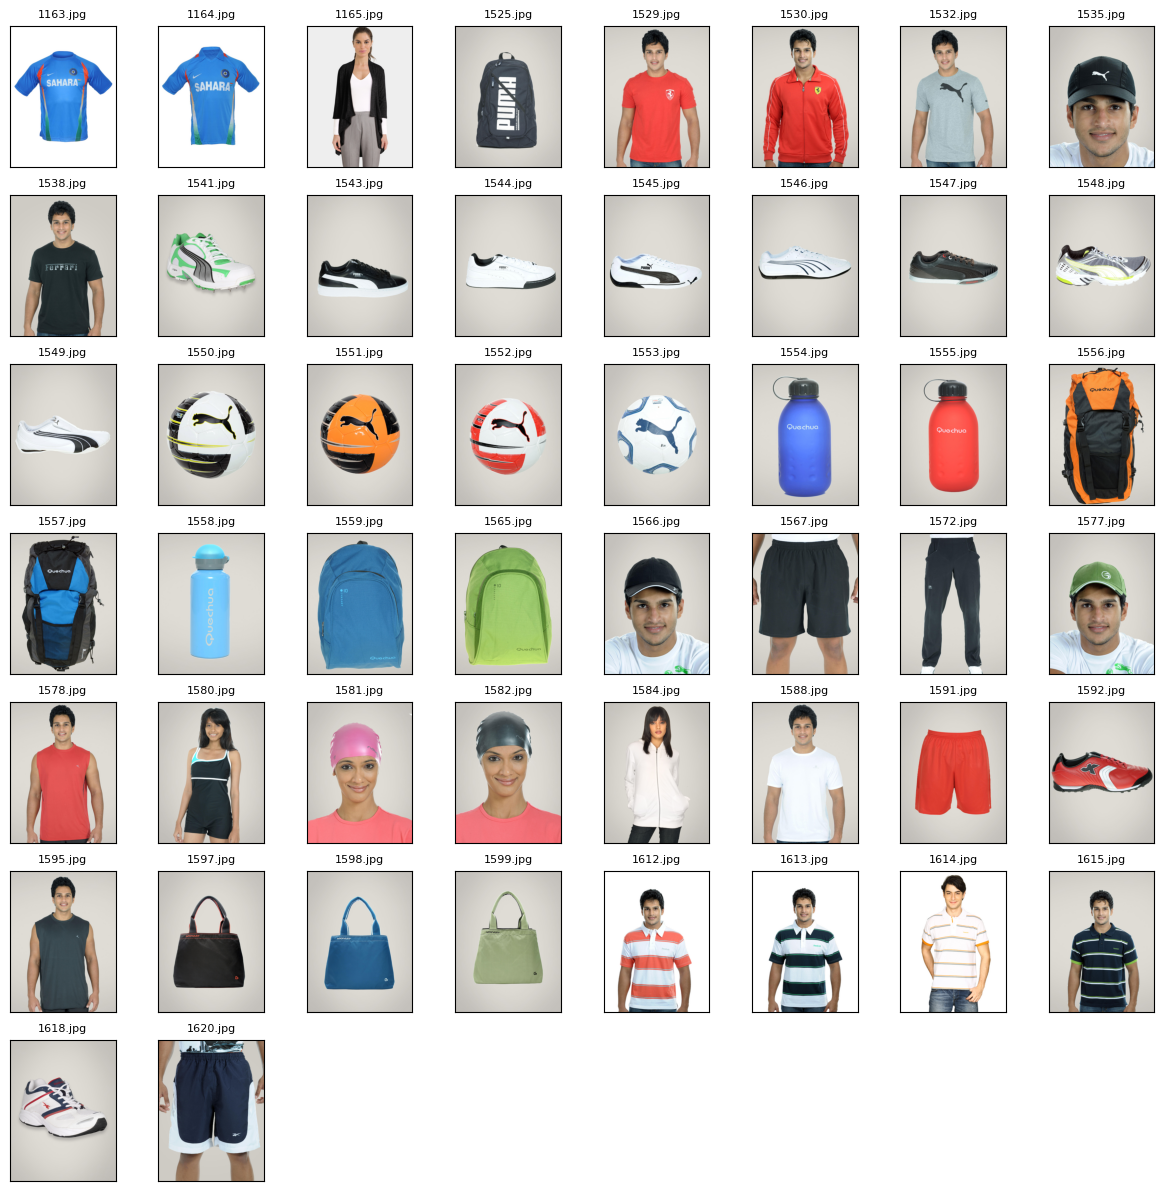

In [70]:
# Посмотрим выбранные (target) изображения из тренировочного набора
image_paths = [os.path.join(TRAIN_TARGET_DIR, img_id + '.jpg') for img_id in train_target_ids]

show_image_grid_from_paths(image_paths[:50], rows=7, cols=8)
print()

In [24]:
# Сформируем датафрейм из тренировочных табличных данных
table_data_list = []

for img_id in train_ids:
    json_path = os.path.join(STYLES_DIR, img_id + '.json')
    
    with open(json_path, 'r', encoding='utf-8') as f:
        file_data = json.load(f)

    # Получим содержимое раздела 'data'
    file_data = file_data['data']

    table_data = {}

    # Выберем признаки из заготовленного списка
    for feature in features_list:
        if feature in file_data:
            table_data[feature] = file_data[feature]
        else:
            table_data[feature] = None
            
    table_data_list.append(table_data)

train_table_df = pd.DataFrame(table_data_list, index=range(len(table_data_list)))
print(f'Размер тренировочного датафрейма с табличными данными: {train_table_df.shape}')
train_table_df

Размер тренировочного датафрейма с табличными данными: (1000, 28)


id   price  discountedPrice styleType  productTypeId  \
0    1163   895.0            895.0       DEL            219   
1    1164  1595.0           1595.0         P            289   
2    1165  2495.0           2495.0         D            219   
3    1525  1299.0           1299.0         P            597   
4    1526  1299.0           1299.0         P            294   
..    ...     ...              ...       ...            ...   
995  2981   799.0            479.0         P            289   
996  2982   999.0            999.0         P            310   
997  2983  1299.0           1299.0         P            289   
998  2984   899.0            899.0         P            289   
999  2985  1199.0           1199.0         P            289   

          articleNumber     visualTag  \
0        409962-480-895                 
1    Nike Sahara Jersey  eoss:PREMIUM   
2           Nike Jersey                 
3               6818802                 
4               6814201                 
..                  ...           ...   
995          557234-06                  
996           557248-01                 
997          558682-02                  
998           65261514                  
999           652618-03                 

                                   productDisplayName  \
0    Nike Sahara Team India Fanwear Round Neck Jersey   
1             Nike Men Blue T20 Indian Cricket Jersey   
2                 Nike Mean Team India Cricket Jersey   
3                        Puma Deck Navy Blue Backpack   
4                         Puma Big Cat Backpack Black   
..                                                ...   
995              Puma Men's Hawaian Ocan Blue T-shirt   
996                              Puma Women White Top   
997          Puma Women's Graphic V-Neck Grey T-shirt   
998          Puma Men's Power Cat Graphic Red T-shirt   
999   Puma Men's Football Smash Graphic Black T-shirt   

                          variantName  myntraRating  ...  season  year  \
0                    Roundneck Jersey             1  ...  Summer  2011   
1                     Collared Jersey             0  ...  Winter  2015   
2                    Authentic Jersey             0  ...  Summer  2013   
3                       Deck Backpack             0  ...    Fall  2010   
4                    Big Cat Backpack             0  ...    Fall  2010   
..                                ...           ...  ...     ...   ...   
995                 Tee2-Hawaian Ocan             1  ...    Fall  2010   
996                          tank top             1  ...    Fall  2011   
997           Wn's Graphic V-neck Tee             1  ...    Fall  2010   
998  PowerCat 1.10 Cotton Graphic Tee             1  ...    Fall  2010   
999        Football Smash Graphic Tee             0  ...    Fall  2010   

      usage   vat               displayCategories weight navigationId  \
0    Sports   5.5                Sports Wear,Sale      0            0   
1    Sports   5.5                     Sports Wear      0            0   
2    Sports   5.5                     Sports Wear      0            0   
3    Casual  14.5                     Accessories      0            0   
4    Sports  14.5                     Accessories      0            0   
..      ...   ...                             ...    ...          ...   
995  Casual   5.5                     Casual Wear      0            0   
996  Casual   5.5                     Casual Wear      0            0   
997  Casual   5.5  Sale and Clearance,Casual Wear      0         1080   
998  Casual   5.5                     Casual Wear      0            0   
999  Sports   5.5                     Sports Wear      0            0   

                                        landingPageUrl codEnabled isEMIEnabled  
0    Tshirts/Nike/Nike-Sahara-Team-India-Fanwear-Ro...       True         True  
1    Tshirts/Nike/Nike-Men-Blue-T20-Indian-Cricket-...       True         True  
2    Tshirts/Nike/Nike-Mean-Team-India-Cricket-Jers...       Tr

#### Тестовые данные

In [25]:
# Получим имена всех тестовых изображений
test_images = [f for f in os.listdir(TEST_IMG_DIR)]
test_ids = [os.path.splitext(filename)[0] for filename in test_images]
print(f'Тестовые изображения: {test_ids[0]}-{test_ids[len(test_ids)-1]} ({len(test_ids)} всего).')

test_targets = [f for f in os.listdir(TEST_TARGET_DIR)]
test_target_ids = [os.path.splitext(filename)[0] for filename in test_targets]
print(f'Тестовые изображения с высоким CTR: {test_target_ids} ({len(test_target_ids)} всего).')

Тестовые изображения: 2986-4119 (1000 всего).
Тестовые изображения с высоким CTR: ['2994', '3042', '3043', '3049', '3052', '3054', '3071', '3131', '3159', '3161', '3177', '3183', '3313', '3314', '3315', '3317', '3318', '3319', '3320', '3321', '3322', '3323', '3324', '3325', '3327', '3328', '3329', '3330', '3332', '3336', '3341', '3382', '3389', '3409', '3411', '3416', '3428', '3431', '3440', '3445', '3446', '3447', '3448', '3460', '3518', '3523', '3525', '3552', '3570', '3584', '3597', '3598', '3599', '3601', '3612', '3614', '3616', '3617', '3641', '3646', '3653', '3656', '3662', '3664', '3666', '3667', '3671', '3672', '3673', '3676', '3677', '3685', '3689', '3690', '3691', '3692', '3693', '3694', '3705', '3706', '3707', '3708', '3709', '3723', '3728', '3729', '3730', '3731', '3732', '3733', '3734', '3735', '3738', '3741', '3742', '3743', '3744', '3745', '3746', '3762', '3767', '3768', '3769', '3770', '3771', '3772', '3773', '3774', '3775', '3776', '3777', '3778', '3779', '3780', '3785

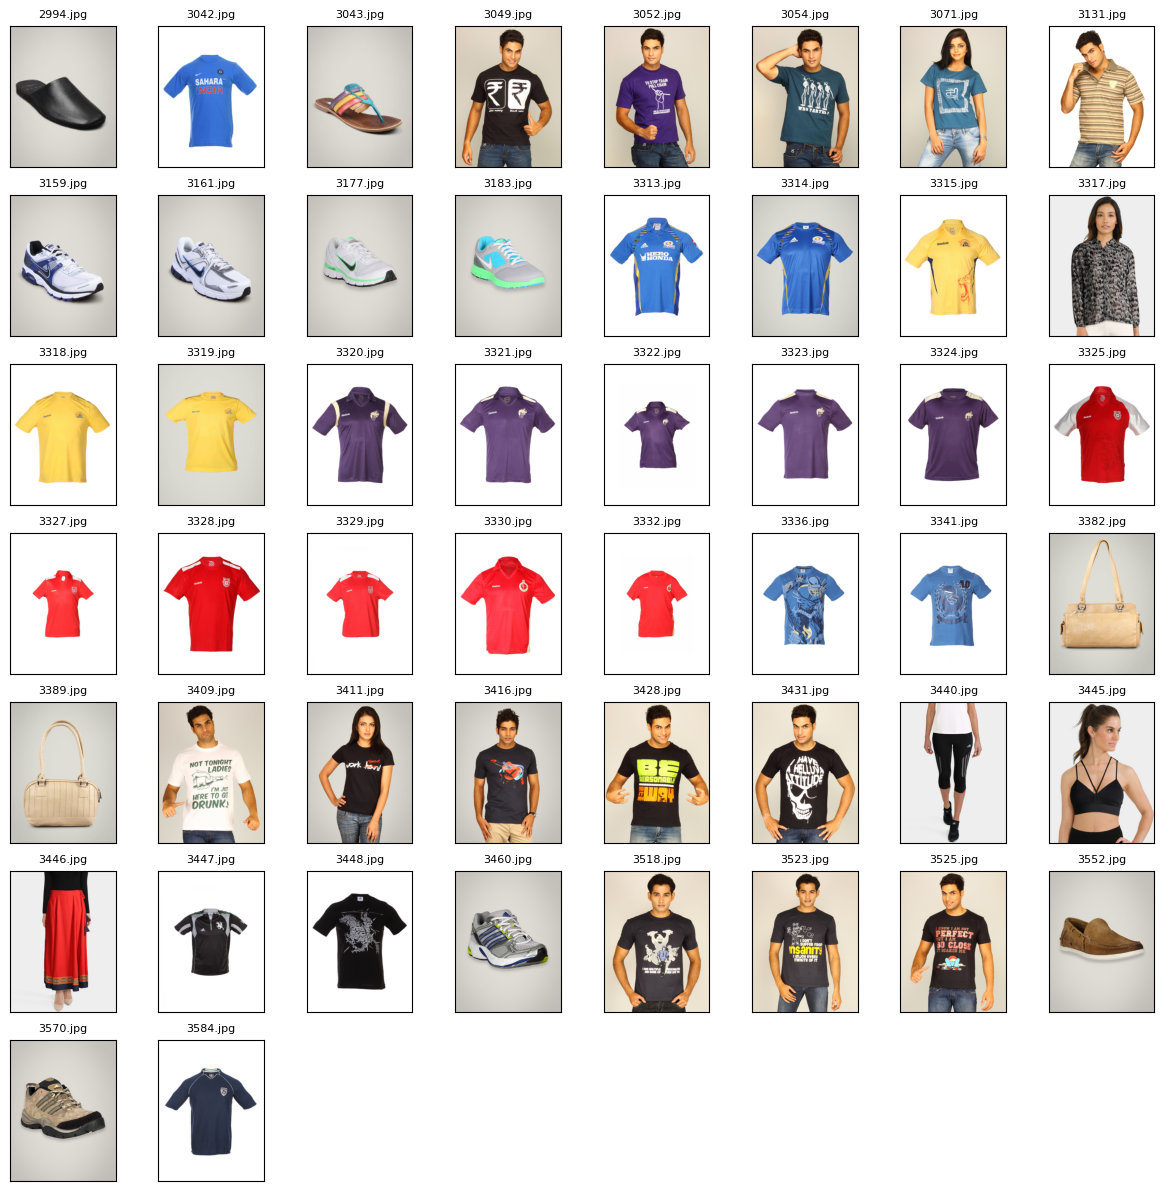

In [71]:
# Посмотрим выбранные (target) изображения из тестового набора
image_paths = [os.path.join(TEST_TARGET_DIR, img_id + '.jpg') for img_id in test_target_ids]

show_image_grid_from_paths(image_paths[:50], rows=7, cols=8)
print()

In [28]:
# Сформируем датафрейм из тестовых табличных данных
table_data_list = []

for img_id in test_ids:
    json_path = os.path.join(STYLES_DIR, img_id + '.json')
    
    with open(json_path, 'r', encoding='utf-8') as f:
        file_data = json.load(f)

    # Получим содержимое раздела 'data'
    file_data = file_data['data']

    table_data = {}

    # Выберем признаки из заготовленного списка
    for feature in features_list:
        if feature in file_data:
            table_data[feature] = file_data[feature]
        else:
            table_data[feature] = None
            
    table_data_list.append(table_data)

test_table_df = pd.DataFrame(table_data_list, index=range(len(table_data_list)))
print(f'Размер тестового датафрейма с табличными данными: {test_table_df.shape}')
test_table_df

Размер тестового датафрейма с табличными данными: (1000, 28)


id  price  discountedPrice styleType  productTypeId  articleNumber  \
0    2986    799              799         P            289     815456-03    
1    2987   2385             2385         P            288   ID0247 BROWN   
2    2988   1799             1799         P            288     5639 - BK    
3    2994   1495             1495         P            323        CLM-928   
4    2996    475              475       DEL            289       DUSG 049   
..    ...    ...              ...       ...            ...            ...   
995  4113   2199             2199         P            288  1F03M44001134   
996  4114   1399             1399       DEL            323     81SU143201   
997  4117   2699             2699         P            288       35156708   
998  4118   1899             1899         P            288       91397702   
999  4119   1899             1899         P            288       91397701   

    visualTag                             productDisplayName  \
0                          Puma Men's Splatter Green T-shirt   
1                         iD Men's Casual Leather Brown Shoe   
2                   Numero Uno Men Casual Graphic Black Shoe   
3                            Carlton London Men Black Sandal   
4              DUSG Men's Freedom Organic Cotton Red T-shirt   
..        ...                                            ...   
995                              Fila Men's Bruno White Shoe   
996                           Fila Men Obsidian Black Sandal   
997                         Puma Unisex Punk White Blue Shoe   
998                Puma Unisex Mid Pixles Olive Orange Shoes   
999                     Puma Unisex Mid Pixles Navy Red Shoe   

                                    variantName  myntraRating  ...  season  \
0                                  Splatter Tee             1  ...    Fall   
1                          casual leather shoes             0  ...  Summer   
2    Casual Black Shoes with numero uno graphic             1  ...    Fall   
3                            Black Mens Sandals             0  ...    Fall   
4               DUSG - Freedom - Organic Cotton             0  ...    Fall   
..                                          ...           ...  ...     ...   
995                                       BRUNO             1  ...  Summer   
996                                    OBSIDIAN             0  ...  Summer   
997                           917 lo punk shoes             0  ...  Summer   
998                              917 Mid Pixles             0  ...  Summer   
999                              917 Mid Pixles             0  ...  Summer   

     year   usage   vat               displayCategories weight navigationId  \
0    2010  Casual   5.5  Sale and Clearance,Casual Wear      0            0   
1    2012  Casual  14.5                        Footwear      0           18   
2    2010  Casual  14.5                        Footwear      0           18   
3    2010  Casual  14.5                        Footwear      0           22   
4    2010  Casual   5.5                     Casual Wear      0         1080   
..    ...     ...   ...                             ...    ...          ...   
995  2011  Casual  14.5                   Footwear,Sale      0           18   
996  2011  Casual  14.5                   Footwear,Sale      0            0   
997  2011  Casual  14.5                   Footwear,Sale      0          603   
998  2011  Casual  14.5                   Footwear,Sale      0          603   
999  2011  Casual  14.5                   Footwear,Sale      0            0   

                                        landingPageUrl codEnabled isEMIEnabled  
0    Tshirts/Puma/Puma-Mens-Splatter-Green-T-shirt/...       True         True  
1    Casual-Shoes/ID/iD-Mens-Casual-Leather-Brown-S...       True         True  
2    Casual-Shoes/Numero-Uno/Numero-Uno-Men-Casual-...       True         True  
3    Sandals/Carlton-London/Carlton-London-Men-Blac...       True         True  
4    Tshirts/Do-u-spea

## Формирование эмбедденгов

#### Препроцессинг изображений

In [29]:
def process_image(image_path, img_size=IMG_SIZE):
    """
    Препроцессинг изображения
    """
    image = tf.io.read_file(image_path)
    
    # Конвертация тензор
    image = tf.image.decode_jpeg(image, channels=3)
    
    # Ресайз изображения до необходимого размера с паддингом
    image = tf.image.resize_with_pad(image, target_height=img_size, target_width=img_size, antialias=True) 
        
    return image

In [30]:
def get_image_label(image_path, label):
    """
    Получаем путь до изображения и лейбл.
    Возвращаем кортеж (изображение, лейбл).
    """
    image = process_image(image_path)
    return image, label

In [31]:
BATCH_SIZE = 32

# Формируем батчи из изображений
def create_data_batches(X, batch_size=BATCH_SIZE):
    print('Формируем батчи...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(process_image).batch(batch_size)
    return data_batch

#### Подготовка модели

In [33]:
# Возьмем EfficientNetV2B0
from keras_cv_attention_models import efficientnet

base_model = efficientnet.EfficientNetV2B0(pretrained="imagenet", 
                                           include_preprocessing=True,
                                           num_classes=0, # убираем "голову" модели
                                           input_shape=(IMG_SIZE, IMG_SIZE, 3) # 224 - для модели это стандартный размер, ничего не изменится
                                          )

>>>> Load pretrained from: /home/roman/.keras/models/efficientnetv2-b0-imagenet.h5


In [34]:
# Можно посмотреть архитектуру модели
base_model.summary()

Model: "efficientnet_v2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          0         ['input_2[0][0]']             
 tion)                                                                                            
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['normalization_1[0][0]']     
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 112, 112, 32)         128       ['stem_conv[0

In [35]:
# Вместе с "головой" исчез слой пуллиинга, из-за чего модель будет возвращать многомерные эмбедденги
# Поэтому добавляем слой пуллинга, чтобы формировался одномерный эмбеддинг
def create_model(base_model=base_model):
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D()
    ])
    
    return model

In [36]:
# Можно увидеть, как вместо 3-хмерного эмбеддинга (7, 7, 1280) будет получаться 1-мерный эмбеддинг (1280).
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet_v2-b0 (Functi  (None, 7, 7, 1280)        5919312   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
Total params: 5919312 (22.58 MB)
Trainable params: 5858704 (22.35 MB)
Non-trainable params: 60608 (236.75 KB)
_________________________________________________________________


#### Формирование тренировочных эмбеддингов

In [37]:
# Пути до тренировочных изображений
train_img_paths = [os.path.join(TRAIN_IMG_DIR, img_name + '.jpg') for img_name in train_ids]
train_img_paths[:10]

['fashion-dataset/images_train/1163.jpg',
 'fashion-dataset/images_train/1164.jpg',
 'fashion-dataset/images_train/1165.jpg',
 'fashion-dataset/images_train/1525.jpg',
 'fashion-dataset/images_train/1526.jpg',
 'fashion-dataset/images_train/1528.jpg',
 'fashion-dataset/images_train/1529.jpg',
 'fashion-dataset/images_train/1530.jpg',
 'fashion-dataset/images_train/1531.jpg',
 'fashion-dataset/images_train/1532.jpg']

In [38]:
train_input_data = create_data_batches(train_img_paths)

Формируем батчи...


In [39]:
# Проверим, что изображения конвертировались в тензоры
train_input_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [41]:
%%time
# Запускаем модель для формирования тренировочных эмбеддингов
train_embeddings = model.predict(train_input_data, verbose=1)

32/32 [==============================] - 2s 74ms/step
CPU times: user 19.4 s, sys: 917 ms, total: 20.3 s
Wall time: 2.46 s


In [42]:
# Проверим форму полученных эмбеддингов
train_embeddings.shape

(1000, 1280)

#### Формирование тестовых эмбеддингов

In [43]:
# Пути до тестовых изображений
test_img_paths = [os.path.join(TEST_IMG_DIR, img_name + '.jpg') for img_name in test_ids]
test_img_paths[:10]

['fashion-dataset/images_test/2986.jpg',
 'fashion-dataset/images_test/2987.jpg',
 'fashion-dataset/images_test/2988.jpg',
 'fashion-dataset/images_test/2994.jpg',
 'fashion-dataset/images_test/2996.jpg',
 'fashion-dataset/images_test/3009.jpg',
 'fashion-dataset/images_test/3011.jpg',
 'fashion-dataset/images_test/3012.jpg',
 'fashion-dataset/images_test/3013.jpg',
 'fashion-dataset/images_test/3014.jpg']

In [44]:
test_input_data = create_data_batches(test_img_paths)

Формируем батчи...


In [45]:
%%time
# Запускаем модель для формирования тестовых эмбеддингов
test_embeddings = model.predict(test_input_data, verbose=1)

32/32 [==============================] - 3s 77ms/step
CPU times: user 19.5 s, sys: 527 ms, total: 20 s
Wall time: 2.56 s


## Работа с CatBoost

Поскольку необходимо сравнить три подхода: 
- использование только табличных данных, 
- использование только эмбеддингов,
- использование и табличных данных, и эмбеддингов,

то создадим функцию, которая будут формировать соответствующие наборы данных.

In [46]:
# Колонки для удаления - id и неинформативные колонки
drop_cols = ['id', 'label', 'articleNumber', 'landingPageUrl']
# Колонки для перевода в тип "категории" для лучшего понимания их CatBoost'ом
categorical_features = ['styleType', 'productTypeId', 'visualTag', 'productDisplayName', 'variantName', 
                        'brandName', 'ageGroup', 'gender', 'baseColour', 'colour1', 
                        'colour2', 'fashionType', 'season', 'usage', 'displayCategories']

In [47]:
# Формирование датасета из табличных данных и эмбеддингов
def process_data(features_df, embeddings, target_ids, categorical_cols=None, 
                 drop_cols=['id', 'label'], table_only=False, embed_only=False, merged=False):
    """
    Функция принимает данные, обрабатывает их и подготавливает для использования в CatBoost.
    target_ids: список изображений, которые обладают целевым признаком.
    features_df: датафрейм c табличными признаками.
    embeddings: эмбедденги изображений.
    drop_cols: список колонок, которые необходимо удалить.
    categorical_cols: список признаков-категорий.
    Функция возвращает X, y, cat_features_indices, merged_df.
    Если данные для инференса, а не для обучения (target_ids пустой), тогда функция вернет пустой 'y'.
    """
    features_df['id'] = features_df['id'].astype(str).str.strip()

    # Создадим датафрейм из эмбеддингов изображений
    embeddings_df = pd.DataFrame(embeddings)
    embeddings_df.columns = [f'embed_{i}' for i in range(embeddings.shape[1])]
    embeddings_df['id'] = features_df['id'].values 

    if embed_only:
        result_df = embeddings_df.copy()
    elif table_only:
        result_df = features_df.copy()
    elif merged:
        # Объединим табличные признаки и эмбедденги
        result_df = pd.merge(features_df, embeddings_df, on='id')
        
    # Добавляем колонку с целевым признаком (1 - есть, 0 - нет)
    result_df['label'] = 0 
    result_df.loc[result_df['id'].isin(target_ids), 'label'] = 1
    y = result_df['label']
   
    # Удалим лишние колонки
    X = result_df.drop(drop_cols, axis=1)
    
    if table_only or merged:
        # Конвертируем некоторые колонки в корректный формат
        X['weight'] = pd.to_numeric(X['weight'], errors='coerce')
        X['year'] = pd.to_datetime(X['year'], format='%Y').dt.year

        # Преобразуем признаки в формат категорий - CatBoost сможет лучше понимать эти признаки
        for feature in categorical_cols:
            if feature in X.columns:
                # Обработка отсутствующий значений в колонке
                X[feature] = X[feature].fillna('MISSING')
                # Конвертация в формат категории
                X[feature] = X[feature].astype('category')

        # Готовим список индексов колонок, преобразованныех в категории
        cat_features_indices = [X.columns.get_loc(col) for col in categorical_features if col in X.columns]
    elif embed_only:
        cat_features_indices = None

    return X, y, cat_features_indices, result_df

#### Обучение модели CatBoost только на табличных данных

In [48]:
# Сформируем датасет из табличных данных
X, y, cat_features_indices, _ = process_data(features_df=train_table_df, 
                                             embeddings=train_embeddings,
                                             target_ids=train_target_ids,
                                             drop_cols=drop_cols, 
                                             categorical_cols=categorical_features,
                                             table_only=True)

# Проверим, как сформировался датасет
print(f'Размер датасета из табличных данных: X={X.shape}, y={y.shape}.')
print(f'Количество элементов с целевым CTR: {sum(y)}')
X[:3]

Размер датасета из табличных данных: X=(1000, 25), y=(1000,).
Количество элементов с целевым CTR: 268


price  discountedPrice styleType productTypeId     visualTag  \
0   895.0            895.0       DEL           219                 
1  1595.0           1595.0         P           289  eoss:PREMIUM   
2  2495.0           2495.0         D           219                 

                                 productDisplayName       variantName  \
0  Nike Sahara Team India Fanwear Round Neck Jersey  Roundneck Jersey   
1           Nike Men Blue T20 Indian Cricket Jersey   Collared Jersey   
2               Nike Mean Team India Cricket Jersey  Authentic Jersey   

   myntraRating  catalogAddDate brandName  ... fashionType  season  year  \
0             1      1461658417      Nike  ...     Fashion  Summer  2011   
1             0      1461658417      Nike  ...     Fashion  Winter  2015   
2             0      1461658417      Nike  ...     Fashion  Summer  2013   

    usage  vat displayCategories weight  navigationId codEnabled  isEMIEnabled  
0  Sports  5.5  Sports Wear,Sale      0             0       True          True  
1  Sports  5.5       Sports Wear      0             0       True          True  
2  Sports  5.5       Sports Wear      0             0       True          True  

[3 rows x 25 columns]

In [49]:
# Создадим тренировочный и проверочный наборы данных
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)

# Обучим CatBoost
table_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC', # Лучше подходит для несбалансированных данных
    random_seed=42,
    scale_pos_weight=(len(y) - sum(y)) / sum(y),  # балансируем данные
    verbose=100
)

table_model.fit(
    X_train, y_train,
    cat_features=cat_features_indices,
    eval_set=(X_val, y_val),
    plot=True
)
print()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8156931	best: 0.8156931 (0)	total: 53.4ms	remaining: 53.4s
100:	test: 0.8678625	best: 0.8678625 (100)	total: 315ms	remaining: 2.81s
200:	test: 0.8744365	best: 0.8747652 (197)	total: 559ms	remaining: 2.22s
300:	test: 0.8757983	best: 0.8759391 (258)	total: 828ms	remaining: 1.92s
400:	test: 0.8747183	best: 0.8761270 (311)	total: 1.12s	remaining: 1.67s
500:	test: 0.8763148	best: 0.8772070 (494)	total: 1.4s	remaining: 1.39s
600:	test: 0.8754226	best: 0.8772070 (494)	total: 1.68s	remaining: 1.12s
700:	test: 0.8743896	best: 0.8772070 (494)	total: 1.96s	remaining: 834ms
800:	test: 0.8752817	best: 0.8772070 (494)	total: 2.23s	remaining: 554ms
900:	test: 0.8750000	best: 0.8772070 (494)	total: 2.5s	remaining: 275ms
999:	test: 0.8757044	best: 0.8772070 (494)	total: 2.77s	remaining: 0us

bestTest = 0.8772069872
bestIteration = 494

Shrink model to first 495 iterations.



#### Обучение модели CatBoost только на эмбеддингах

In [50]:
# Сформируем датасет из эмбеддингов
X, y, _, __ = process_data(features_df=train_table_df, 
                           embeddings=train_embeddings,
                           target_ids=train_target_ids,
                           embed_only=True)

# Проверим, как сформировался датасет
print(f'Размер датасета из табличных данных: X={X.shape}, y={y.shape}.')
print(f'Количество элементов с целевым CTR: {sum(y)}')
X[:3]

Размер датасета из табличных данных: X=(1000, 1280), y=(1000,).
Количество элементов с целевым CTR: 268


embed_0   embed_1   embed_2   embed_3   embed_4   embed_5   embed_6  \
0 -0.097885 -0.080805 -0.185647 -0.151897 -0.168198  0.319415 -0.092455   
1 -0.088910 -0.087167 -0.184409 -0.152376 -0.125848 -0.080363 -0.112538   
2 -0.002899 -0.136903 -0.085705 -0.143614 -0.189203 -0.175428 -0.103456   

    embed_7   embed_8   embed_9  ...  embed_1270  embed_1271  embed_1272  \
0 -0.116160 -0.121513 -0.075549  ...   -0.018291    0.072861   -0.189658   
1 -0.118320 -0.149101 -0.076346  ...   -0.086512   -0.046533   -0.179577   
2 -0.118493 -0.114009  0.464287  ...   -0.133754   -0.051105    0.028101   

   embed_1273  embed_1274  embed_1275  embed_1276  embed_1277  embed_1278  \
0    0.006746   -0.164853    0.112848   -0.122916   -0.112621   -0.151318   
1   -0.016134   -0.096978    0.195541   -0.083709   -0.058156   -0.156065   
2   -0.094240   -0.091221   -0.164126   -0.070295   -0.148281   -0.161057   

   embed_1279  
0   -0.138694  
1   -0.129211  
2    0.086030  

[3 rows x 1280 columns]

In [51]:
# Создадим тренировочный и проверочный наборы данных
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)

# Параметры подобраны в результате экспериментов - для достижения наилучшего результата
# Результат у эмбеддингов лучше, потому что целевые признаки - визуальные
# Обучим CatBoost
embed_model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.031,
    depth=3,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    scale_pos_weight=(len(y) - sum(y)) / sum(y), 
    verbose=100
)

embed_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    plot=True
)
print()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7926371	best: 0.7926371 (0)	total: 10.9ms	remaining: 21.8s
100:	test: 0.9652986	best: 0.9652986 (100)	total: 650ms	remaining: 12.2s
200:	test: 0.9796206	best: 0.9799023 (199)	total: 1.32s	remaining: 11.9s
300:	test: 0.9859128	best: 0.9861007 (299)	total: 2.19s	remaining: 12.4s
400:	test: 0.9861007	best: 0.9866642 (395)	total: 2.85s	remaining: 11.3s
500:	test: 0.9870398	best: 0.9871337 (477)	total: 3.53s	remaining: 10.6s
600:	test: 0.9872276	best: 0.9876033 (521)	total: 4.2s	remaining: 9.79s
700:	test: 0.9874155	best: 0.9876033 (521)	total: 4.87s	remaining: 9.02s
800:	test: 0.9874155	best: 0.9876503 (739)	total: 5.53s	remaining: 8.28s
900:	test: 0.9872276	best: 0.9876503 (739)	total: 6.18s	remaining: 7.54s
1000:	test: 0.9873216	best: 0.9876503 (739)	total: 6.85s	remaining: 6.83s
1100:	test: 0.9875094	best: 0.9876503 (739)	total: 7.53s	remaining: 6.14s
1200:	test: 0.9876503	best: 0.9876503 (739)	total: 8.19s	remaining: 5.45s
1300:	test: 0.9876503	best: 0.9876972 (1251)	total: 

#### Обучение модели CatBoost на табличных данных и эмбеддингах

In [52]:
# Сформируем датасет из табличных данных и эмбеддингов
X, y, cat_features_indices, _ = process_data(features_df=train_table_df, 
                                             embeddings=train_embeddings,
                                             target_ids=train_target_ids,
                                             drop_cols=drop_cols, 
                                             categorical_cols=categorical_features,
                                             merged=True)

# Проверим, как сформировался датасет
print(f'Размер датасета из табличных данных: X={X.shape}, y={y.shape}.')
print(f'Количество элементов с целевым CTR: {sum(y)}')
X[:3]

Размер датасета из табличных данных: X=(1000, 1305), y=(1000,).
Количество элементов с целевым CTR: 268


price  discountedPrice styleType productTypeId     visualTag  \
0   895.0            895.0       DEL           219                 
1  1595.0           1595.0         P           289  eoss:PREMIUM   
2  2495.0           2495.0         D           219                 

                                 productDisplayName       variantName  \
0  Nike Sahara Team India Fanwear Round Neck Jersey  Roundneck Jersey   
1           Nike Men Blue T20 Indian Cricket Jersey   Collared Jersey   
2               Nike Mean Team India Cricket Jersey  Authentic Jersey   

   myntraRating  catalogAddDate brandName  ... embed_1270 embed_1271  \
0             1      1461658417      Nike  ...  -0.018291   0.072861   
1             0      1461658417      Nike  ...  -0.086512  -0.046533   
2             0      1461658417      Nike  ...  -0.133754  -0.051105   

  embed_1272 embed_1273 embed_1274 embed_1275 embed_1276  embed_1277  \
0  -0.189658   0.006746  -0.164853   0.112848  -0.122916   -0.112621   
1  -0.179577  -0.016134  -0.096978   0.195541  -0.083709   -0.058156   
2   0.028101  -0.094240  -0.091221  -0.164126  -0.070295   -0.148281   

  embed_1278  embed_1279  
0  -0.151318   -0.138694  
1  -0.156065   -0.129211  
2  -0.161057    0.086030  

[3 rows x 1305 columns]

In [53]:
# Создадим тренировочный и проверочный наборы данных
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)

# Обучим CatBoost
merged_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=3,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    scale_pos_weight=(len(y) - sum(y)) / sum(y),  # балансируем данные
    verbose=100
)

merged_model.fit(
    X_train, y_train,
    cat_features=cat_features_indices,
    eval_set=(X_val, y_val),
    plot=True
)
print()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7997511	best: 0.7997511 (0)	total: 9.81ms	remaining: 9.8s
100:	test: 0.9698535	best: 0.9698535 (97)	total: 805ms	remaining: 7.16s
200:	test: 0.9829545	best: 0.9834711 (187)	total: 1.66s	remaining: 6.59s
300:	test: 0.9871807	best: 0.9876972 (280)	total: 2.48s	remaining: 5.76s
400:	test: 0.9883077	best: 0.9886833 (397)	total: 3.33s	remaining: 4.97s
500:	test: 0.9894346	best: 0.9894346 (494)	total: 4.27s	remaining: 4.25s
600:	test: 0.9892468	best: 0.9895285 (501)	total: 5.2s	remaining: 3.45s
700:	test: 0.9893877	best: 0.9896225 (658)	total: 6.11s	remaining: 2.61s
800:	test: 0.9895755	best: 0.9897633 (780)	total: 6.91s	remaining: 1.72s
900:	test: 0.9897164	best: 0.9898573 (884)	total: 7.7s	remaining: 846ms
999:	test: 0.9898573	best: 0.9899981 (933)	total: 8.48s	remaining: 0us

bestTest = 0.9899981217
bestIteration = 933

Shrink model to first 934 iterations.



#### Протестируем полученные модели

In [54]:
# Получим тестовый датасет из табличных данных
X_test, y_test, _, __ = process_data(features_df=test_table_df, 
                                     embeddings=test_embeddings,
                                     target_ids=test_target_ids,
                                     drop_cols=drop_cols, 
                                     categorical_cols=categorical_features,
                                     table_only=True)

# Сделаем предсказания на тестовых данных
test_preds_table = table_model.predict_proba(X_test)[:, 1]

# Посмотрим, как выглядит датасет
print(f'Размер датасета из табличных данных: X={X_test.shape}, y={y_test.shape}.')
print(f'Количество элементов с целевым CTR: {sum(y_test)}')
X_test[:3]

Размер датасета из табличных данных: X=(1000, 25), y=(1000,).
Количество элементов с целевым CTR: 180


price  discountedPrice styleType productTypeId visualTag  \
0    799              799         P           289             
1   2385             2385         P           288             
2   1799             1799         P           288             

                         productDisplayName  \
0         Puma Men's Splatter Green T-shirt   
1        iD Men's Casual Leather Brown Shoe   
2  Numero Uno Men Casual Graphic Black Shoe   

                                  variantName  myntraRating  catalogAddDate  \
0                                Splatter Tee             1      1472135919   
1                        casual leather shoes             0      1457613843   
2  Casual Black Shoes with numero uno graphic             1      1460357544   

    brandName  ... fashionType  season  year   usage   vat  \
0        Puma  ...     Fashion    Fall  2010  Casual   5.5   
1          ID  ...     Fashion  Summer  2012  Casual  14.5   
2  Numero Uno  ...     Fashion    Fall  2010  Casual  14.5   

                displayCategories weight  navigationId codEnabled  \
0  Sale and Clearance,Casual Wear      0             0       True   
1                        Footwear      0            18       True   
2                        Footwear      0            18       True   

   isEMIEnabled  
0          True  
1          True  
2          True  

[3 rows x 25 columns]

In [55]:
# Получим тестовый датасет из эмбеддингов
X_test, y_test, _, __ = process_data(features_df=test_table_df, 
                                     embeddings=test_embeddings,
                                     target_ids=test_target_ids,
                                     embed_only=True)

# Сделаем предсказания на тестовых данных
test_preds_embed = embed_model.predict_proba(X_test)[:, 1]

# Посмотрим, как выглядит датасет
print(f'Размер датасета из табличных данных: X={X_test.shape}, y={y_test.shape}.')
print(f'Количество элементов с целевым CTR: {sum(y_test)}')
X_test[:3]

Размер датасета из табличных данных: X=(1000, 1280), y=(1000,).
Количество элементов с целевым CTR: 180


embed_0   embed_1   embed_2   embed_3   embed_4   embed_5   embed_6  \
0 -0.132938 -0.070366 -0.133518  0.497346 -0.162174  0.227744  0.519161   
1 -0.158919 -0.160064 -0.185590 -0.194661 -0.085625 -0.196777 -0.170123   
2 -0.188400 -0.157055 -0.176700 -0.171108 -0.120667 -0.170980  0.205013   

    embed_7   embed_8   embed_9  ...  embed_1270  embed_1271  embed_1272  \
0 -0.131956  0.060380 -0.097185  ...   -0.084575   -0.052018   -0.136574   
1 -0.157452 -0.146644 -0.065471  ...   -0.009696   -0.121413   -0.056547   
2 -0.049660 -0.184025 -0.191106  ...   -0.163427   -0.129594    0.194034   

   embed_1273  embed_1274  embed_1275  embed_1276  embed_1277  embed_1278  \
0    0.156002    0.430314    0.443266   -0.073802   -0.000933   -0.103407   
1   -0.127789   -0.183579   -0.143718   -0.200649   -0.183212    1.116250   
2   -0.114581    0.303772   -0.148067   -0.102521   -0.174826    0.104516   

   embed_1279  
0   -0.056467  
1   -0.179749  
2   -0.106085  

[3 rows x 1280 columns]

In [56]:
# Получим тестовый датасет из табличных данных и эмбеддингов
X_test, y_test, _, result_df = process_data(features_df=test_table_df, 
                                            embeddings=test_embeddings,
                                            target_ids=test_target_ids,
                                            drop_cols=drop_cols, 
                                            categorical_cols=categorical_features,
                                            merged=True)

# Сделаем предсказания на тестовых данных
test_preds_merged = merged_model.predict_proba(X_test)[:, 1]

# Проверим, как сформировался датасет
print(f'Размер датасета из табличных данных: X={X_test.shape}, y={y_test.shape}.')
print(f'Количество элементов с целевым CTR: {sum(y_test)}')
X_test[:3]

Размер датасета из табличных данных: X=(1000, 1305), y=(1000,).
Количество элементов с целевым CTR: 180


price  discountedPrice styleType productTypeId visualTag  \
0    799              799         P           289             
1   2385             2385         P           288             
2   1799             1799         P           288             

                         productDisplayName  \
0         Puma Men's Splatter Green T-shirt   
1        iD Men's Casual Leather Brown Shoe   
2  Numero Uno Men Casual Graphic Black Shoe   

                                  variantName  myntraRating  catalogAddDate  \
0                                Splatter Tee             1      1472135919   
1                        casual leather shoes             0      1457613843   
2  Casual Black Shoes with numero uno graphic             1      1460357544   

    brandName  ... embed_1270 embed_1271 embed_1272 embed_1273 embed_1274  \
0        Puma  ...  -0.084575  -0.052018  -0.136574   0.156002   0.430314   
1          ID  ...  -0.009696  -0.121413  -0.056547  -0.127789  -0.183579   
2  Numero Uno  ...  -0.163427  -0.129594   0.194034  -0.114581   0.303772   

  embed_1275 embed_1276  embed_1277 embed_1278  embed_1279  
0   0.443266  -0.073802   -0.000933  -0.103407   -0.056467  
1  -0.143718  -0.200649   -0.183212   1.116250   -0.179749  
2  -0.148067  -0.102521   -0.174826   0.104516   -0.106085  

[3 rows x 1305 columns]

In [57]:
# Посчитаем точность сделанных предсказаний на тестовых данных

# Create a DataFrame to compare predictions
preds_df = pd.DataFrame({
    'id': result_df['id'],
    'prediction_table': test_preds_table,
    'prediction_embed': test_preds_embed,
    'prediction_merged': test_preds_merged,
    'label': result_df['label']
})

print('Итоговая таблица для сравнения качества предсказаний по тестовым данным:')
print(preds_df[:10])

accuracy_df = preds_df.copy()
accuracy_df['pred_label_table'] = (accuracy_df['prediction_table'] >= 0.5).astype(int)
accuracy_df['pred_label_embed'] = (accuracy_df['prediction_embed'] >= 0.5).astype(int)
accuracy_df['pred_label_merged'] = (accuracy_df['prediction_merged'] >= 0.5).astype(int)
accuracy_df['correct_table'] = accuracy_df['pred_label_table'] == accuracy_df['label']
accuracy_df['correct_embed'] = accuracy_df['pred_label_embed'] == accuracy_df['label']
accuracy_df['correct_merged'] = accuracy_df['pred_label_merged'] == accuracy_df['label']

total = len(accuracy_df)

# Точность предсказания только по табличным данным
correct_amount = accuracy_df['correct_table'].sum()
accuracy = correct_amount / total * 100
print(f'\nТочность предсказания только по табличным признакам: {accuracy}%.\n')

# Точность предсказания только по эмбеддингам
correct_amount = accuracy_df['correct_embed'].sum()
accuracy = correct_amount / total * 100
print(f'Точность предсказания только по эмбеддингам: {accuracy}%.\n')

# Точность предсказания по табличным данным и эмбеддингам
correct_amount = accuracy_df['correct_merged'].sum()
accuracy = correct_amount / total * 100
print(f'Точность предсказания по табличным признакам и эмбеддингам: {accuracy}%.')

Итоговая таблица для сравнения качества предсказаний по тестовым данным:
     id  prediction_table  prediction_embed  prediction_merged  label
0  2986          0.026021          0.002515           0.002373      0
1  2987          0.081214          0.000052           0.000145      0
2  2988          0.504445          0.001263           0.006105      0
3  2994          0.732767          0.989893           0.976463      1
4  2996          0.016199          0.011901           0.007928      0
5  3009          0.013189          0.004475           0.002899      0
6  3011          0.012301          0.000708           0.000472      0
7  3012          0.015795          0.004574           0.002418      0
8  3013          0.033669          0.001300           0.003491      0
9  3014          0.020108          0.000087           0.000083      0

Точность предсказания только по табличным признакам: 78.0%.

Точность предсказания только по эмбеддингам: 95.5%.

Точность предсказания по табличным признак

## Поиск наиболее важных параметров для достижения целевого признака

Изучим наиболее успешную модель - которая использует и табличные признаки, и эмбедденги.

In [58]:
# Проанализируем результаты обучения модели

# Получаем важные признаки
feature_importance = merged_model.get_feature_importance()
feature_names = X_test.columns

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print('10 самых важных признаков:')
print(importance_df.head(10))

# Отдельно выделим 5 самых важных эмбеддинг признаков
top_embedding_features = importance_df[importance_df['feature'].str.startswith('embed_')].head(5)
print('\n5 самых важных эмбеддинг признаков:')
print(top_embedding_features)

# Отдельно выделим 5 самых важных табличных признаков
top_descriptive_features = importance_df[~importance_df['feature'].str.startswith('embed_')].head(5)
print('\n5 самых важных табличных признаков:')
print(top_descriptive_features)

10 самых важных признаков:
         feature  importance
449    embed_424   11.042110
561    embed_536    7.847967
526    embed_501    5.133356
850    embed_825    3.786338
9      brandName    2.877682
482    embed_457    2.834974
781    embed_756    1.794663
1243  embed_1218    1.671082
592    embed_567    1.542060
451    embed_426    1.324989

5 самых важных эмбеддинг признаков:
       feature  importance
449  embed_424   11.042110
561  embed_536    7.847967
526  embed_501    5.133356
850  embed_825    3.786338
482  embed_457    2.834974

5 самых важных табличных признаков:
              feature  importance
9           brandName    2.877682
2           styleType    1.109520
7        myntraRating    0.248585
13            colour1    0.152856
20  displayCategories    0.134533


Видно, что наибольшую роль играют именно эмбедденги. В то же время, нет каких-то определяющих признаков. Скорее всего эмбеддинги влияют на результат не по одиночке, а в комбинации. Попробуем найти эти комбинации.

Если бы присутствовали влиятельные табличные признаки - можно было изучить какие параметры и их значения преобладают в тренировочных данных, чтобы затем их систематизировать.

#### Поиск комбинаций эмбеддингов

In [59]:
# Снова сформируем тренировочный и тестовый набор - только из эмбеддингов

# Тренировочный датасет
X_train, y_train, _, __ = process_data(features_df=train_table_df, 
                           embeddings=train_embeddings,
                           target_ids=train_target_ids,
                           embed_only=True)

X_test, y_test, _, __ = process_data(features_df=test_table_df, 
                                     embeddings=test_embeddings,
                                     target_ids=test_target_ids,
                                     embed_only=True)

In [60]:
# Получаем важные признаки из модели, обученной на эмбеддингах
feature_importance = embed_model.get_feature_importance()
feature_names = X_test.columns

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print('10 самых важных эмбеддингов:')
print(importance_df.head(10))

10 самых важных эмбеддингов:
         feature  importance
424    embed_424   11.123158
536    embed_536    9.611828
501    embed_501    5.173088
825    embed_825    3.551629
457    embed_457    2.292999
857    embed_857    2.193575
560    embed_560    1.878270
756    embed_756    1.642222
1218  embed_1218    1.587783
680    embed_680    1.429499


Топ 5 эмбеддингов полностью совпадает с топом у общей модели (merged_model).

In [61]:
# Найдем силу взаимодействия признаков
interaction_strength = embed_model.get_feature_importance(type='Interaction')
print('Сила взаимодействия признаков:')
print(interaction_strength)
print(len(interaction_strength))

# Конвертируем в более наглядный формат
interaction_df = pd.DataFrame(interaction_strength, columns=['feature_idx_1', 'feature_idx_2', 'interaction_strength'])
interaction_df['feature_pair'] = list(zip(
    interaction_df['feature_idx_1'].astype(int),
    interaction_df['feature_idx_2'].astype(int)
))

# Отсортируем пары по силе взаимодействия
interaction_df = interaction_df.sort_values('interaction_strength', ascending=False)
print('Топ пар признаков по силе взаимодействия')
print(interaction_df.head(10))

Сила взаимодействия признаков:
[[ 501.          678.            1.28705601]
 [ 240.          536.            1.22693916]
 [ 536.         1069.            1.18790533]
 ...
 [ 557.         1048.            0.        ]
 [ 218.          857.            0.        ]
 [ 172.          525.            0.        ]]
1855
Топ пар признаков по силе взаимодействия
   feature_idx_1  feature_idx_2  interaction_strength feature_pair
0          501.0          678.0              1.287056   (501, 678)
1          240.0          536.0              1.226939   (240, 536)
2          536.0         1069.0              1.187905  (536, 1069)
3          536.0          825.0              1.140226   (536, 825)
4          424.0          857.0              0.865828   (424, 857)
5          501.0          536.0              0.810800   (501, 536)
6          536.0          773.0              0.587717   (536, 773)
7          501.0          857.0              0.586970   (501, 857)
8          434.0          756.0             

#### С помощью пар взаимодействия найдем комбинации из наиболее сильных признаков

In [62]:
# Создадим новый список важных признаков с учетом индексов,
# поскольку CatBoost использует только индексы для расчета силы взаимодействия
idx_to_importance = {idx: importance for idx, importance in enumerate(feature_importance)}

# Проверим, что список корректный - посмотрим один пример
print(f'У признака номер 424 имя: {feature_names[424]} и важность {idx_to_importance[424]:.3f}')

У признака номер 424 имя: embed_424 и важность 11.123


In [64]:
# Отфильтруем признаки, оставим только наиболее важные (топ 5%)
top_importance = max(feature_importance)
min_importance = 0.05 * top_importance  
print(f'Минимальная граница важности признака: {min_importance:.2f}')

filtered_interactions = []

for _, row in interaction_df.iterrows():
    # Отфильтруем оба признака из пары взаимодействия
    imp1 = idx_to_importance.get(int(row['feature_idx_1']), 0)
    imp2 = idx_to_importance.get(int(row['feature_idx_2']), 0)
    
    # Оставим пару, только если оба признака имеют высокую важность
    if imp1 > min_importance and imp2 > min_importance:
        filtered_interactions.append(row)

filtered_interaction_df = pd.DataFrame(filtered_interactions)
print(f'Исходное число пар признаков: {len(interaction_df)} -> Отфильтрованное число пар: {len(filtered_interaction_df)}')

Минимальная граница важности признака: 0.56
Исходное число пар признаков: 1855 -> Отфильтрованное число пар: 149


In [65]:
# Построим граф, чтобы выявить связи у более крупных групп признаков
G = nx.Graph()

for _, row in filtered_interaction_df.iterrows():
    idx1 = int(row['feature_idx_1'])
    idx2 = int(row['feature_idx_2'])
    
    # На ребра графа добавим силу взаимодействия и важность признаков
    G.add_edge(
        idx1, 
        idx2, 
        weight=row['interaction_strength'],
        imp1=idx_to_importance[idx1],
        imp2=idx_to_importance[idx2]
    )

print(f'Построен граф с {G.number_of_nodes()} вершинами и {G.number_of_edges()} ребрами.')

Построен граф с 34 вершинами и 149 ребрами.


In [66]:
# Найдем группы признаков
communities = list(community.greedy_modularity_communities(G))

# Вычислим гибридную метрику (плотность + важность признака)
# Установим порог для этой метрики
VALIDATION_THRESHOLD = 1.0

community_results = []

for i, nodes in enumerate(communities):
    nodes = sorted(nodes)
    
    # Получим среднюю важность признака в каждой группе
    importances = [idx_to_importance[node] for node in nodes]
    avg_imp = sum(importances) / len(importances)
    
    # Вычислим метрики взаимодействия
    sub = G.subgraph(nodes)
    if len(nodes) > 1:
        density = sub.number_of_edges() / (len(nodes)*(len(nodes)-1)/2)
    else:
        density = 0
    total_strength = sum(data['weight'] for _, _, data in sub.edges(data=True))
    
    # Ключевая метрика - гибридная (плотность + важность признака)
    hybrid_score = avg_imp * (density ** 0.5)
    
    community_results.append({
        'id': i+1,
        'nodes': nodes,
        'size': len(nodes),
        'avg_importance': avg_imp,
        'density': density,
        'total_strength': total_strength,
        'hybrid_score': hybrid_score
    })

# Отсортируем группы по гибридной метрике
sorted_communities = sorted(community_results, key=lambda x: x['hybrid_score'], reverse=True)

In [67]:
print(f'Найдено {len(sorted_communities)} возможных группы признаков.\n')

# Выведем найденные группы
for comm in sorted_communities:  
    print(f'Группа №{comm["id"]} (Гибридная метрика: {comm["hybrid_score"]:.2f})')
    print(f'Размер: {comm["size"]} признаков | Средняя важность: {comm["avg_importance"]:.2f} | Плотность: {comm["density"]:.2f}')

    # Признаки и их важность
    feature_details = []
    for node in comm['nodes']:
        feat_name = feature_names[node]
        imp = idx_to_importance[node]
        feature_details.append(f'{feat_name} (imp={imp:.2f})')
    print(f'Признаки: {feature_details}')

    # Итог - это действительно связанная группа из важных признаков или нет
    if comm['hybrid_score'] > VALIDATION_THRESHOLD:
        status = 'сильная группа признаков'
    else:
        status = 'слабая группа признаков'
    print(f'Статус: {status}\n')

Найдено 3 возможных группы признаков.

Группа №1 (Гибридная метрика: 1.83)
Размер: 12 признаков | Средняя важность: 2.32 | Плотность: 0.62
Признаки: ['embed_349 (imp=0.94)', 'embed_446 (imp=0.56)', 'embed_501 (imp=5.17)', 'embed_536 (imp=9.61)', 'embed_678 (imp=1.02)', 'embed_680 (imp=1.43)', 'embed_773 (imp=0.64)', 'embed_825 (imp=3.55)', 'embed_857 (imp=2.19)', 'embed_975 (imp=0.80)', 'embed_1069 (imp=1.19)', 'embed_1195 (imp=0.70)']
Статус: сильная группа признаков

Группа №2 (Гибридная метрика: 1.03)
Размер: 12 признаков | Средняя важность: 1.79 | Плотность: 0.33
Признаки: ['embed_18 (imp=0.65)', 'embed_84 (imp=0.76)', 'embed_329 (imp=0.98)', 'embed_424 (imp=11.12)', 'embed_426 (imp=1.13)', 'embed_567 (imp=0.76)', 'embed_594 (imp=0.84)', 'embed_668 (imp=0.96)', 'embed_756 (imp=1.64)', 'embed_814 (imp=1.19)', 'embed_836 (imp=0.60)', 'embed_1086 (imp=0.79)']
Статус: сильная группа признаков

Группа №3 (Гибридная метрика: 0.74)
Размер: 10 признаков | Средняя важность: 1.13 | Плотность

Далее можно проверить - дают ли предсказания по этим группам признаков лучше результат чем предсказания по набору с таким же количеством признаков, но случайных. Это бы однозначно доказало, что найденные группы признаков действительно влияют на целевой параметр. Пока что пропустим этот шаг.

In [107]:
# Функция для получения данных об активации эмбеддингов
def get_activation_scores(community):
    # Получаем список эмбеддингов (признаков) из группы
    features = community['nodes']

    # Нормализуем датасет
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)

    # PCA позволяет найти нелинейные связи между эмбеддингами
    pca = PCA(n_components=1)
    community_data = X_scaled[:, features]
    activation_scores = pca.fit_transform(community_data).flatten()

    return activation_scores

#### Изображения, характерные для первой группы признаков

In [108]:
# Получим данные по активации эмбеддингов для первой группы признаков
activation_scores = get_activation_scores(sorted_communities[0])

# Получим отсортированный индекс с наибольшей силой активации выбранных эмбеддингов
top_score_indices = np.argsort(activation_scores)[-30:]
# Поправим сортировку (argsor по-умолчанию сортирует по возрастанию)
top_score_indices = top_score_indices[::-1]

# Аналогично для изображений с наименьшей силой активации выбранных эмбеддингов
bottom_score_indices = np.argsort(activation_scores)[:30]
bottom_score_indices = bottom_score_indices[::-1]

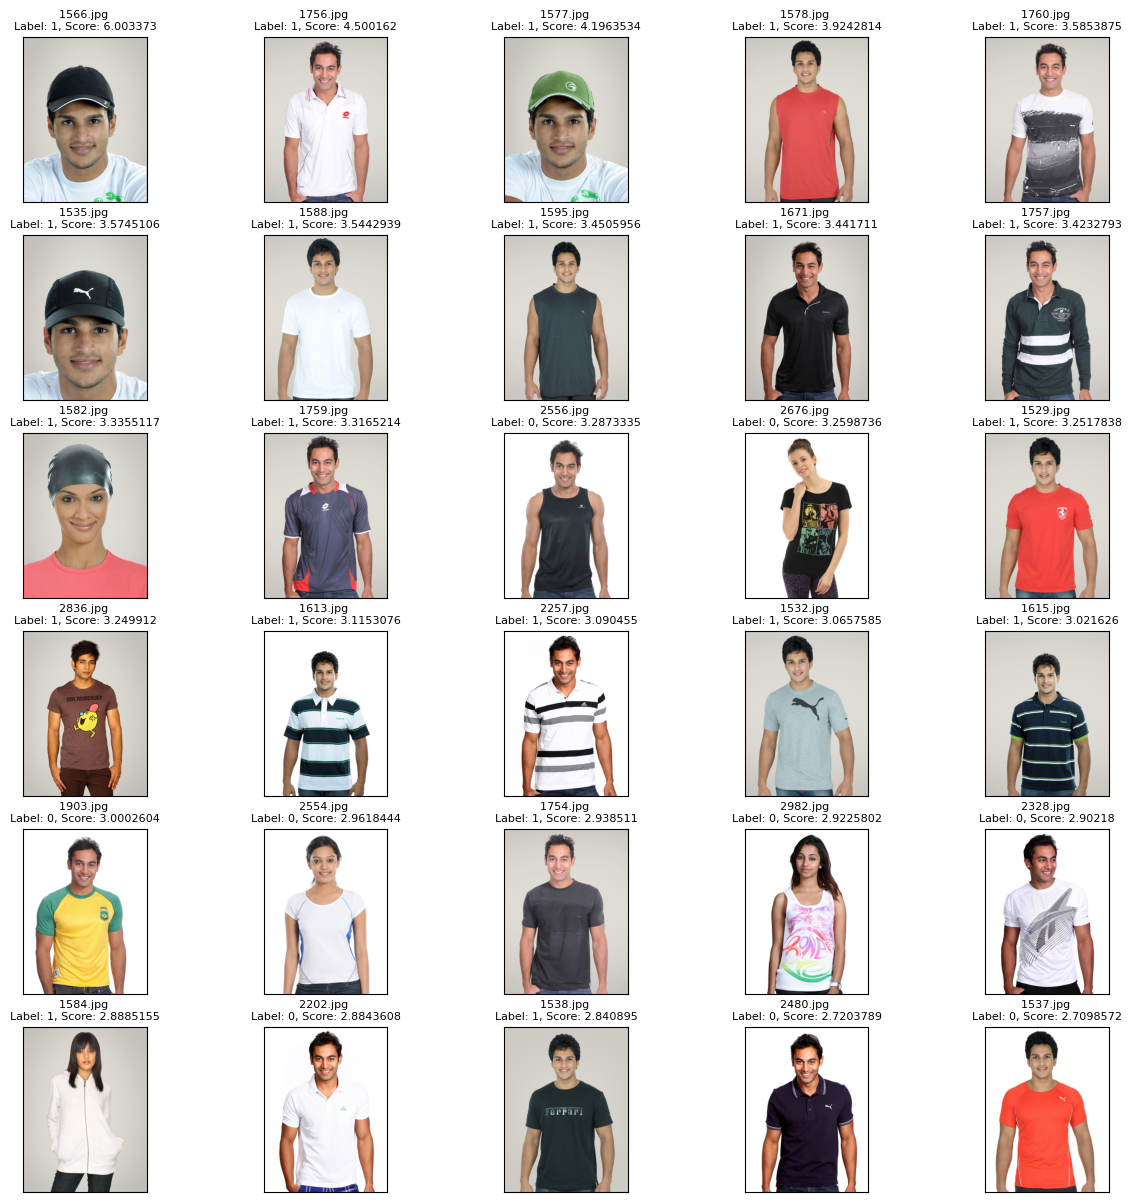

In [109]:
# Выведем 30 изображений с самыми большими значениями активации
# Можно заметить, что изображения содержати либо серый фон, футболки, что близко к признакам, которые обозначен в начале (целевые)
top_train_ids = []
top_train_labels = {}

for idx in top_score_indices:
    train_id = train_ids[idx]
    top_train_ids.append(train_id)
    top_train_labels[train_id] = '\nLabel: ' + str(y_train[idx]) + ', Score: ' + str(activation_scores[idx])

top_train_img_paths = [os.path.join(TRAIN_IMG_DIR, img_id + '.jpg') for img_id in top_train_ids]

show_image_grid_from_paths(paths=top_train_img_paths, labels=top_train_labels, rows=6, cols=5)
print()

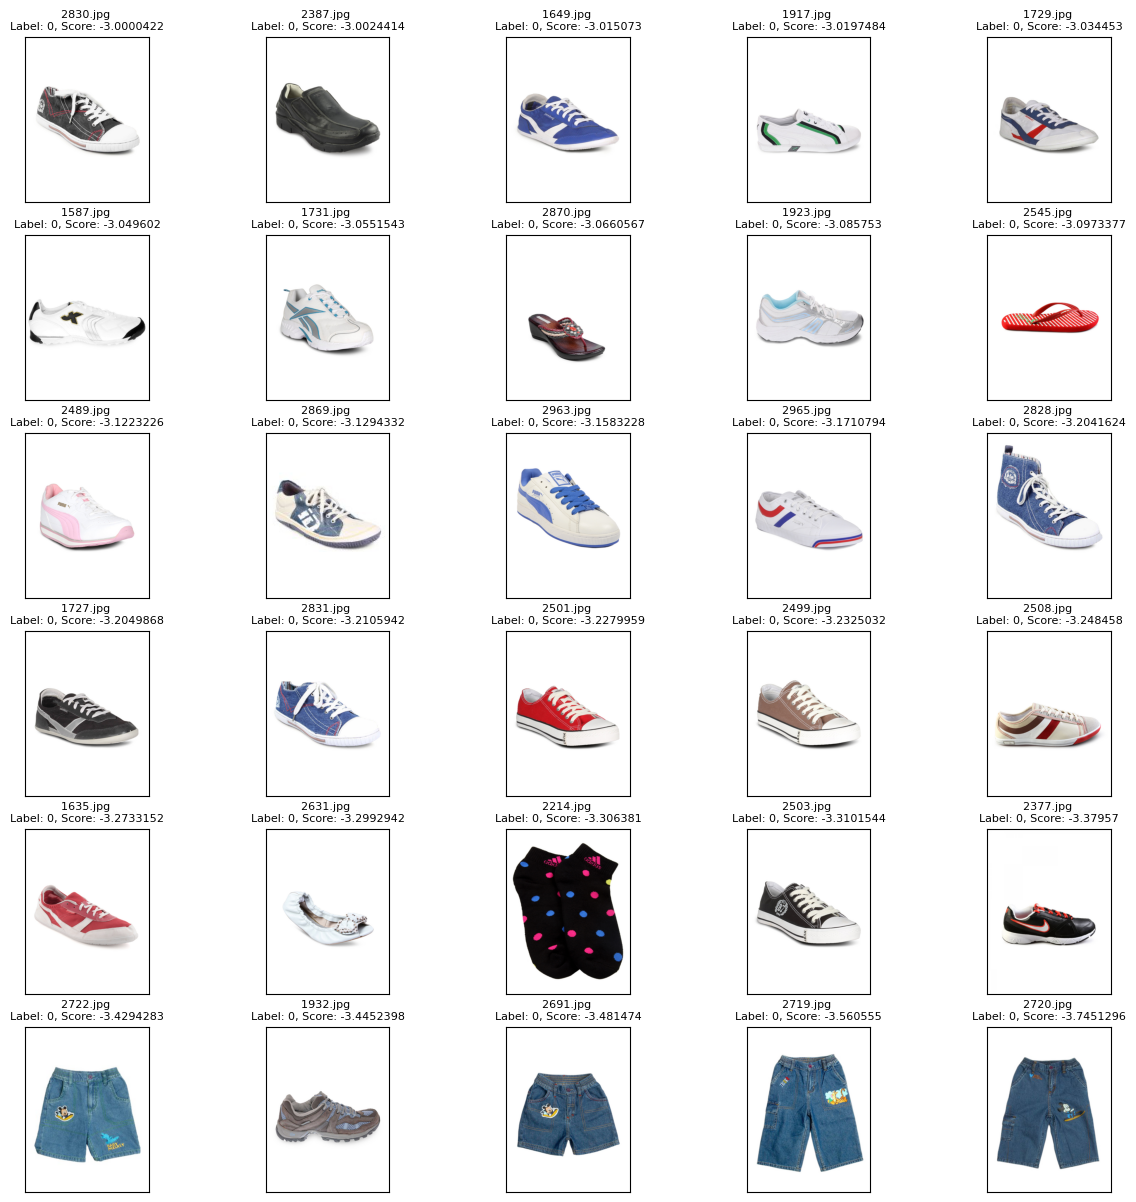

In [111]:
# Выведем 30 изображений с наименьшими значениями активации
# Выведенные изображения не содержат футболок и серого фона - это четко определенные анти-признаки
bottom_train_ids = []
bottom_train_labels = {}

for idx in bottom_score_indices:
    train_id = train_ids[idx]
    bottom_train_ids.append(train_id)
    bottom_train_labels[train_id] = '\nLabel: ' + str(y_train[idx]) + ', Score: ' + str(activation_scores[idx])

bottop_train_img_paths = [os.path.join(TRAIN_IMG_DIR, img_id + '.jpg') for img_id in bottom_train_ids]

show_image_grid_from_paths(paths=bottop_train_img_paths, labels=bottom_train_labels, rows=6, cols=5)
print()

#### Изображения, характерные для второй группы признаков

In [112]:
# Получим данные по активации эмбеддингов для второй группы признаков
activation_scores = get_activation_scores(sorted_communities[1])

# Получим отсортированный индекс с наибольшей силой активации выбранных эмбеддингов
top_score_indices = np.argsort(activation_scores)[-30:]
# Поправим сортировку (argsor по-умолчанию сортирует по возрастанию)
top_score_indices = top_score_indices[::-1]

# Аналогично для изображений с наименьшей силой активации выбранных эмбеддингов
bottom_score_indices = np.argsort(activation_scores)[:30]
bottom_score_indices = bottom_score_indices[::-1]

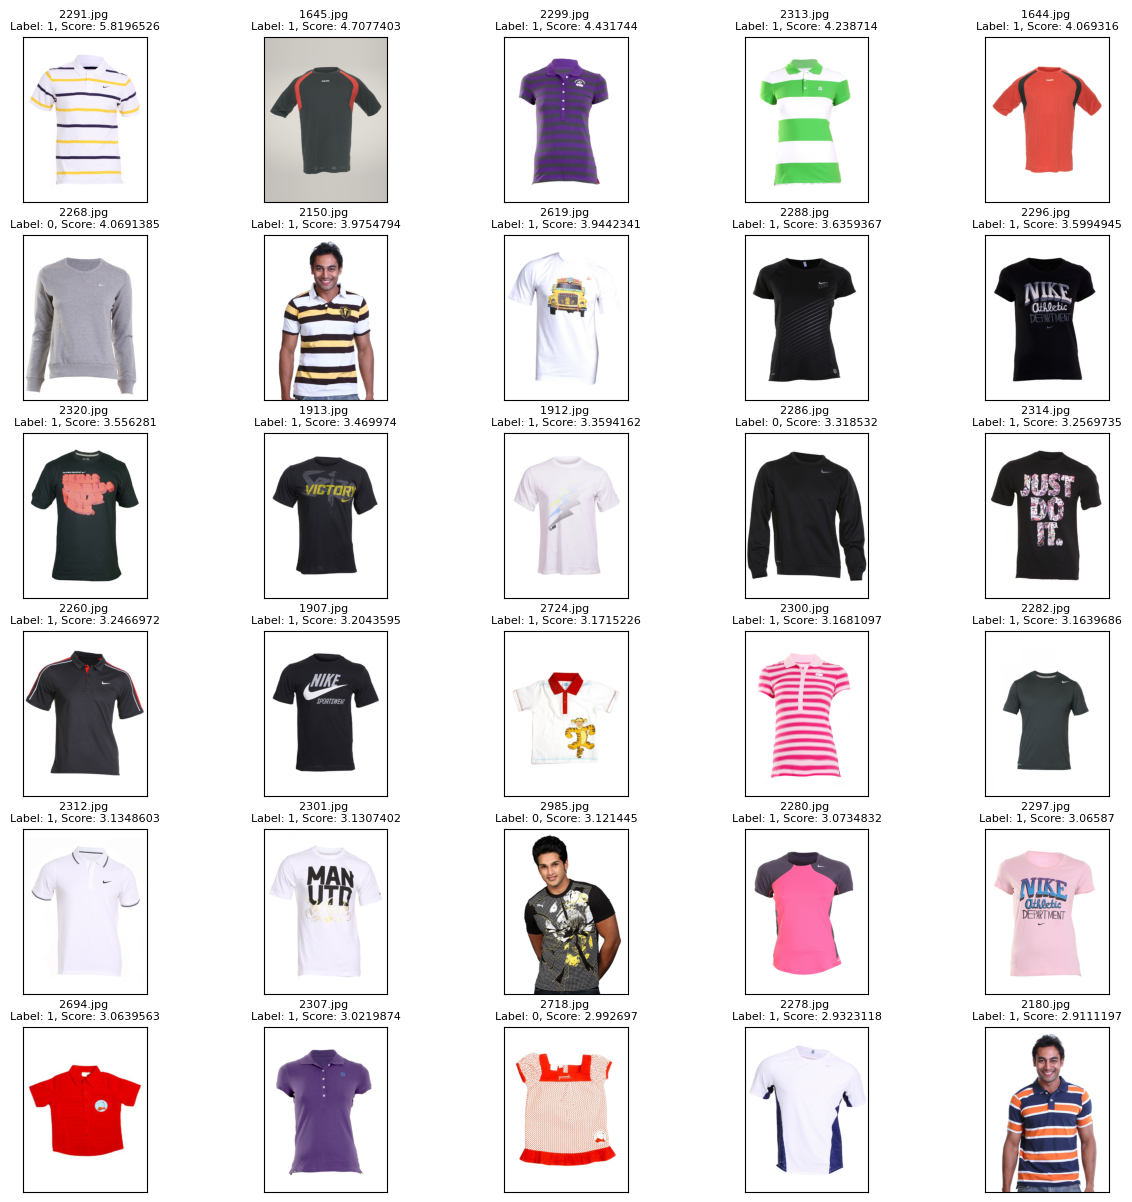

In [113]:
# Выведем 30 изображений с самыми большими значениями активации
# Видно, что преобладают футболки на белом фоне - это из одна из групп признаков, обозначенных в начале (целевых)
top_train_ids = []
top_train_labels = {}

for idx in top_score_indices:
    train_id = train_ids[idx]
    top_train_ids.append(train_id)
    top_train_labels[train_id] = '\nLabel: ' + str(y_train[idx]) + ', Score: ' + str(activation_scores[idx])

top_train_img_paths = [os.path.join(TRAIN_IMG_DIR, img_id + '.jpg') for img_id in top_train_ids]

show_image_grid_from_paths(paths=top_train_img_paths, labels=top_train_labels, rows=6, cols=5)
print()

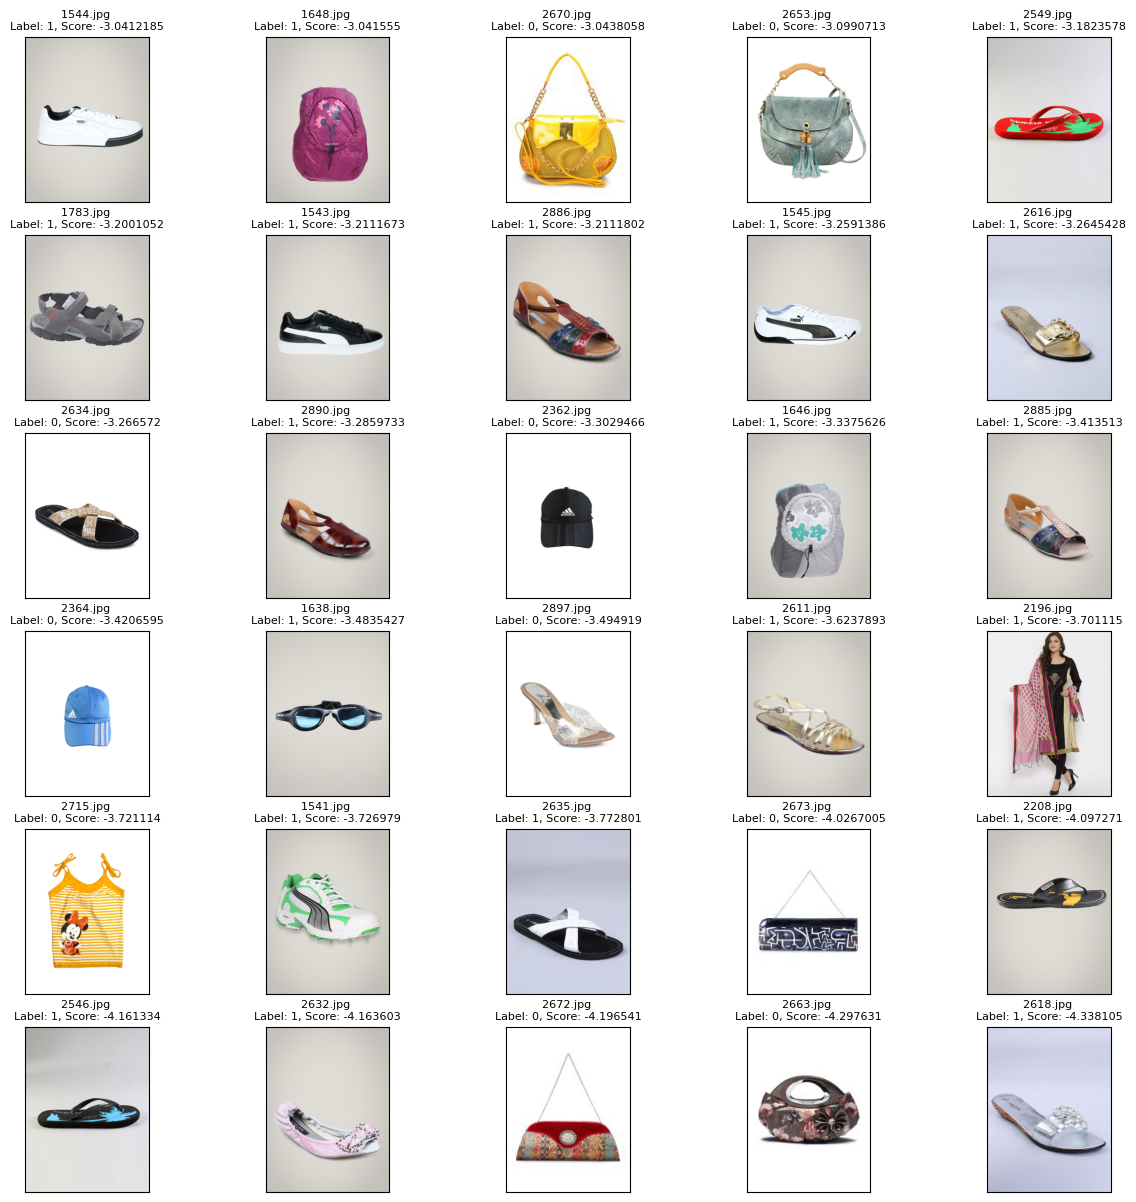

In [114]:
# Выведем 30 изображений с наименьшими значениями активации
# Здесь показаны максимально отличные изображения от показанных выше - нет футболок, много серого фона.
# Но сюда также попали и целевые значения, которые скорее близки к первой группе (с серым фоном).
bottom_train_ids = []
bottom_train_labels = {}

for idx in bottom_score_indices:
    train_id = train_ids[idx]
    bottom_train_ids.append(train_id)
    bottom_train_labels[train_id] = '\nLabel: ' + str(y_train[idx]) + ', Score: ' + str(activation_scores[idx])

bottop_train_img_paths = [os.path.join(TRAIN_IMG_DIR, img_id + '.jpg') for img_id in bottom_train_ids]

show_image_grid_from_paths(paths=bottop_train_img_paths, labels=bottom_train_labels, rows=6, cols=5)
print()

Для более глубокого изученения визуальных признаков можно дообучить CNN-модель на имеющихся данных с использование классификации по CTR. На основе такой модели можно будет построить heatmaps, что позволит точнее идентифицировать визуальные признаки.

Также дообученная модель будет формировать более точные эмбеддинги, что позволит улучшить результаты, полученные в этом ноутбуке результаты.